In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk
import inflect
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nlp_surveillance.classifier import extract_sentence
from nlp_surveillance.pipeline import ExtractSentencesAndLabel, RecommenderLabeling, RecommenderTierAnnotation
from nlp_surveillance.classifier import summarize
from utils.my_utils import split_list_and_distribute_to_new_rows

# Count/Date Classifier: Most Informative Words

In [45]:
df_sent = ExtractSentencesAndLabel('counts').data_output()
df_sent['sentence']= df_sent['sentence'].apply(lambda x: list(set(x.split()) - set(stopwords.words('english'))))
df_sent.head()

,sentence,label
0,"[preparedness, +234(0)708, us, 9700, control, ...",False
1,"[preparedness, +234(0)708, us, 9700, control, ...",False
2,"[preparedness, +234(0)708, us, 9700, control, ...",False
3,"[held, achieve, Goals, LeoneSustainable, Weste...",False
4,"[held, achieve, Goals, LeoneSustainable, Weste...",False


In [46]:
df_sent = split_list_and_distribute_to_new_rows(df_sent, 'sentence')
df_sent.head()

,label,sentence
0,False,preparedness
1,False,+234(0)708
2,False,us
3,False,9700
4,False,control


In [47]:
as_tuples = df_sent.apply(tuple, axis=1).tolist()
as_tuples = [({'word':word}, label) for label, word in as_tuples]
as_tuples

[({'word': 'preparedness'}, False),
 ({'word': '+234(0)708'}, False),
 ({'word': 'us'}, False),
 ({'word': '9700'}, False),
 ({'word': 'control'}, False),
 ({'word': '0010Whatsapp:'}, False),
 ({'word': '5577×Contact'}, False),
 ({'word': 'non-communicable'}, False),
 ({'word': 'year'}, False),
 ({'word': 'established'}, False),
 ({'word': 'Nigeria’s'}, False),
 ({'word': 'Nigeria'}, False),
 ({'word': 'Disease'}, False),
 ({'word': 'challenges'}, False),
 ({'word': '0839SMS'}, False),
 ({'word': 'detection'}, False),
 ({'word': 'epidemics'}, False),
 ({'word': 'diseases.Connect'}, False),
 ({'word': '(NCDC)'}, False),
 ({'word': 'Free'}, False),
 ({'word': '711'}, False),
 ({'word': 'health'}, False),
 ({'word': 'NCDCThe'}, False),
 ({'word': 'Subscribe'}, False),
 ({'word': 'Centre'}, False),
 ({'word': '2011'}, False),
 ({'word': 'enhance'}, False),
 ({'word': '0800'}, False),
 ({'word': 'Control'}, False),
 ({'word': '955'}, False),
 ({'word': 'Number:'}, False),
 ({'word': 'Newsle

In [48]:
clf = nltk.NaiveBayesClassifier.train(as_tuples)
clf.show_most_informative_features(20)

Most Informative Features
                    word = 'variant'        True : False  =     31.1 : 1.0
                    word = 'poultry'        True : False  =     27.1 : 1.0
                    word = 'Laibin'         True : False  =     22.2 : 1.0
                    word = '42-year-old'    True : False  =     22.2 : 1.0
                    word = 'strains.'       True : False  =     19.2 : 1.0
                    word = 'provinces.Aug'   True : False  =     19.2 : 1.0
                    word = '13For'          True : False  =     19.2 : 1.0
                    word = '(H1N2v)'        True : False  =     19.2 : 1.0
                    word = 'straight'       True : False  =     19.2 : 1.0
                    word = 'H1N2'           True : False  =     19.2 : 1.0
                    word = 'Ohio.The'       True : False  =     19.2 : 1.0
                    word = 'fair,'          True : False  =     19.2 : 1.0
                    word = 'Bulgaria,'      True : False  =     17.3 : 1.

In [49]:
df_sent_date = ExtractSentencesAndLabel('dates').data_output()
df_sent_date['sentence']= df_sent_date['sentence'].apply(lambda x: list(set(x.split()) - set(stopwords.words('english'))))
df_sent_date = split_list_and_distribute_to_new_rows(df_sent_date, 'sentence')
as_tuples_date = df_sent_date.apply(tuple, axis=1).tolist()
as_tuples_date = [({'sent':word}, label) for label, word in as_tuples_date]

In [50]:
clf_date = nltk.NaiveBayesClassifier.train(as_tuples_date)
clf_date.show_most_informative_features(20)

Most Informative Features
                    sent = 'worm'           True : False  =      6.0 : 1.0
                    sent = 'occurring'      True : False  =      5.3 : 1.0
                    sent = 'Northern'       True : False  =      5.3 : 1.0
                    sent = 'emerging'       True : False  =      5.3 : 1.0
                    sent = 'patients'      False : True   =      4.5 : 1.0
                    sent = 'South'          True : False  =      4.1 : 1.0
                    sent = 'deaths'        False : True   =      3.9 : 1.0
                    sent = 'launches'       True : False  =      3.8 : 1.0
                    sent = 'Syria'          True : False  =      3.8 : 1.0
                    sent = 'NDOH-WHO'       True : False  =      3.8 : 1.0
                    sent = 'admitted'       True : False  =      3.8 : 1.0
                    sent = 'deaths.'        True : False  =      3.8 : 1.0
                    sent = '22'             True : False  =      3.8 : 1.0

# Recommendation Classifier

In [7]:
df_recommand = RecommenderLabeling().data_output()

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.metrics import classification_report_imbalanced

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
train_texts, dev_texts, train_cats, dev_cats = train_test_split(df_recommand['extracted_text'],
                                                                df_recommand['label'],
                                                                test_size=.2)

text_clf.fit(train_texts, train_cats)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

              precision    recall  f1-score   support

       False       0.96      0.99      0.97       619
        True       0.20      0.07      0.11        28

   micro avg       0.95      0.95      0.95       647
   macro avg       0.58      0.53      0.54       647
weighted avg       0.93      0.95      0.94       647

[[611   8]
 [ 26   2]]
                   pre       rec       spe        f1       geo       iba       sup

      False       0.96      0.99      0.07      0.97      0.27      0.08       619
       True       0.20      0.07      0.99      0.11      0.27      0.06        28

avg / total       0.93      0.95      0.11      0.94      0.27      0.08       647



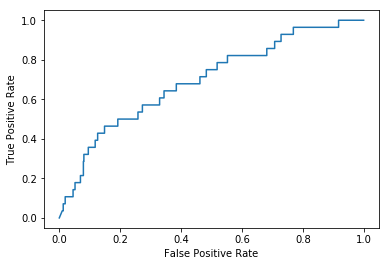

In [14]:
plot_roc(text_clf, dev_texts, dev_cats, 'multinomial')
print(classification_report(dev_cats, text_clf.predict(dev_texts)))
print(confusion_matrix(dev_cats, text_clf.predict(dev_texts)))
print(classification_report_imbalanced(dev_cats, text_clf.predict(dev_texts)))

In [17]:
from sklearn.naive_bayes import ComplementNB

text_clf_c = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', ComplementNB()),
])

text_clf_c.fit(train_texts, train_cats)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False))])

              precision    recall  f1-score   support

       False       0.96      0.99      0.97       619
        True       0.20      0.07      0.11        28

   micro avg       0.95      0.95      0.95       647
   macro avg       0.58      0.53      0.54       647
weighted avg       0.93      0.95      0.94       647

                   pre       rec       spe        f1       geo       iba       sup

      False       0.96      0.99      0.07      0.97      0.27      0.08       619
       True       0.20      0.07      0.99      0.11      0.27      0.06        28

avg / total       0.93      0.95      0.11      0.94      0.27      0.08       647



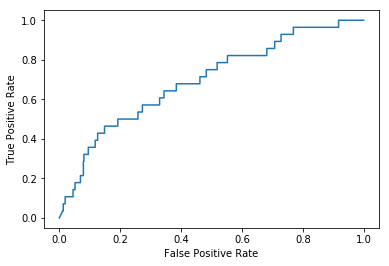

In [18]:
plot_roc(text_clf_c, dev_texts, dev_cats, 'complement')
print(classification_report(dev_cats, text_clf_c.predict(dev_texts)))
print(classification_report_imbalanced(dev_cats, text_clf.predict(dev_texts)))

# SpaCy CNN classifier

In [103]:
"""Train a convolutional neural network text classifier on the
IMDB dataset, using the TextCategorizer component. The dataset will be loaded
automatically via Thinc's built-in dataset loader. The model is added to
spacy.pipeline, and predictions are available via `doc.cats`. For more details,
see the documentation:
* Training: https://spacy.io/usage/training

Compatible with: spaCy v2.0.0+
"""
from __future__ import unicode_literals, print_function
import random
from pathlib import Path
import thinc.extra.datasets

import spacy
from spacy.util import minibatch, compounding




def main(model=None, output_dir=None, n_iter=20, n_texts=2000, init_tok2vec=None):

    output_dir = Path('spacy_output')
    if not output_dir.exists():
        output_dir.mkdir()


    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    textcat = nlp.create_pipe(
        "textcat",
        config={
            "exclusive_classes": False,
            "architecture": "simple_cnn",
        }
    )
    nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it

    # add label to text classifier
    textcat.add_label("Relevant")
    textcat.add_label("Irrelevant")

    # load the IMDB dataset
    print("Loading data...")
    from sklearn.model_selection import train_test_split
    train_texts, dev_texts, train_cats, dev_cats = train_test_split(df_recommand['extracted_text'],
                                                                    df_recommand['label'],
                                                                    test_size=.2)
    
    train_cats = [{"Relevant": bool(y), "Irrelevant": not bool(y)} for y in train_cats]
    dev_cats = [{"Relevant": bool(y), "Irrelevant": not bool(y)} for y in dev_cats]
    print(
        "Using ({} training, {} evaluation)".format(
             len(train_texts), len(dev_texts)
        )
    )
    train_data = list(zip(train_texts, [{"cats": cats} for cats in train_cats]))

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        if init_tok2vec is not None:
            with init_tok2vec.open("rb") as file_:
                textcat.model.tok2vec.from_bytes(file_.read())
        print("Training the model...")
        print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))
        batch_sizes = compounding(4.0, 32.0, 1.001)
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            random.shuffle(train_data)
            batches = minibatch(train_data, size=batch_sizes)
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print(
                "{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(  # print a simple table
                    losses["textcat"],
                    scores["textcat_p"],
                    scores["textcat_r"],
                    scores["textcat_f"],
                )
            )

    # test the trained model
    test_text = "This movie sucked"
    doc = nlp(test_text)
    print(test_text, doc.cats)

    if output_dir is not None:
        with nlp.use_params(optimizer.averages):
            nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        print(test_text, doc2.cats)


def load_data(limit=0, split=0.8):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    train_data, _ = thinc.extra.datasets.imdb()
    random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])


def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}


In [104]:
main()

Created blank 'en' model
Loading data...
Using (2585 training, 647 evaluation)
Training the model...
LOSS 	  P  	  R  	  F  
54.105	0.958	0.958	0.958
31.109	0.960	0.958	0.959
16.388	0.961	0.958	0.960
8.000	0.960	0.960	0.960
4.622	0.958	0.960	0.959
3.106	0.960	0.958	0.959
2.476	0.958	0.957	0.957
1.634	0.957	0.957	0.957
1.492	0.957	0.957	0.957
1.265	0.957	0.957	0.957
1.052	0.957	0.957	0.957
1.038	0.957	0.957	0.957
1.022	0.957	0.957	0.957
1.021	0.955	0.957	0.956
0.973	0.955	0.957	0.956
0.953	0.957	0.958	0.958
0.946	0.955	0.957	0.956
0.831	0.955	0.955	0.955
0.834	0.957	0.957	0.957
0.822	0.957	0.957	0.957
This movie sucked {'Relevant': 0.21459360420703888, 'Irrelevant': 0.6485452055931091}
Saved model to spacy_output
Loading from spacy_output
This movie sucked {'Relevant': 0.22368237376213074, 'Irrelevant': 0.6475332379341125}


# Embedded Classifier

In [5]:
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, ADASYN
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.base import TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [115]:
class MeanEmbeddingTransformer(TransformerMixin):
    
    def __init__(self):
        self._vocab, self._E = self._load_words()
        
    
    def _load_words(self):
        E = {}
        vocab = []

        with open('nlp_surveillance/glove.6B.50d.txt', 'r', encoding="utf8") as file:
            for i, line in enumerate(file):
                l = line.split(' ')
                if l[0].isalpha():
                    v = [float(i) for i in l[1:]]
                    E[l[0]] = np.array(v)
                    vocab.append(l[0])
        return np.array(vocab), E            

    
    def _get_word(self, v):
        for i, emb in enumerate(self._E):
            if np.array_equal(emb, v):
                return self._vocab[i]
        return None
    
    def _doc_mean(self, doc):
        return np.mean(np.array([self._E[w.lower().strip()] for w in doc if w.lower().strip() in self._E]), axis=0)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._doc_mean(doc) for doc in X])
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [11]:
def plot_roc(clf, X_test, y_test, name):
    try:
        y_pred = clf.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
    except AttributeError:
        y_pred = clf.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig(f'{name}.pdf', format='pdf')
    plt.plot(fpr, tpr)
    
def print_scores(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    try:
        y_pred = clf.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
    except AttributeError:
        y_pred = clf.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred)
    print(classification_report_imbalanced(y_test, clf.predict(X_test)))
#     print(classification.accuracy_score(y_test, y_pred.round(), normalize=False))
#     print(confusion_matrix(y_pred,y_test))
#     print('F1 score: {:3f}'.format(f1_score(y_test, y_pred.round())))
#     print('AUC score: {:3f}'.format(roc_auc_score(y_test, y_pred)))

In [ ]:
import pandas as pd
df = pd.read_csv('data/recommender/with_label.csv')

In [72]:
df.memory_usage(deep=True).sum()

16167717

In [73]:
df['label'].value_counts()

False    3077
True      155
Name: label, dtype: int64

In [74]:
X = df['extracted_text'].values
y = df['label'].values

In [124]:
def tokenize_and_transform(X, sample_size):
    essays1 = X
    tok_es1 = [word_tokenize(doc) for doc in essays1[:sample_size]]
    met = MeanEmbeddingTransformer()
    X_transform = met.fit_transform(tok_es1)
    return X_transform

In [125]:
X_transform = tokenize_and_transform(X, 3200)

In [126]:
np.savetxt('X_embed.csv', X_transform, delimiter=',')

In [67]:
X_transform = np.loadtxt('X_embed.csv', delimiter=',')

In [68]:
np.shape(X_transform)

(3200, 50)

In [69]:
np.shape(y)

(117,)

In [74]:
# X_train, X_test, y_train, y_test = train_test_split(X_resample,
#                                                     y_resample, stratify=y_resample, random_state=0)



In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_transform,
                                                    y[:3200], random_state=0)
ada = ADASYN(random_state=0)
X_resample, y_resample = ada.fit_sample(X_train, y_train)


In [76]:
rus = RandomOverSampler(random_state=0)
X_resample, y_resample = rus.fit_sample(X_transform, y[:X_transform.shape[0]])

In [110]:
lr = LogisticRegression()
print_scores(lr, X_resample, y_resample, X_test, y_test)
plot_roc(lr, X_test, y_test, 'logistic_regression')

/anaconda3/envs/RKI/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


NameError: name 'classification_report_imbalanced' is not defined

                   pre       rec       spe        f1       geo       iba       sup

      False       0.97      0.77      0.53      0.86      0.63      0.41       762
       True       0.10      0.53      0.77      0.17      0.63      0.39        38

avg / total       0.93      0.75      0.54      0.82      0.63      0.41       800



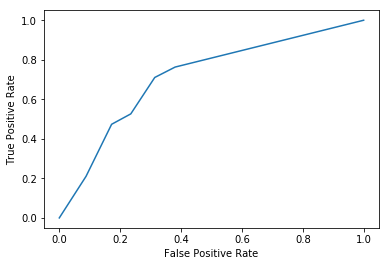

In [220]:
knn = KNeighborsClassifier()
print_scores(knn, X_resample, y_resample, X_test, y_test)
plot_roc(knn, X_test, y_test, 'k_neighbors_clf')

/anaconda3/envs/RKI/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


                   pre       rec       spe        f1       geo       iba       sup

      False       0.95      0.97      0.05      0.96      0.23      0.06       762
       True       0.07      0.05      0.97      0.06      0.23      0.05        38

avg / total       0.91      0.92      0.10      0.92      0.23      0.06       800



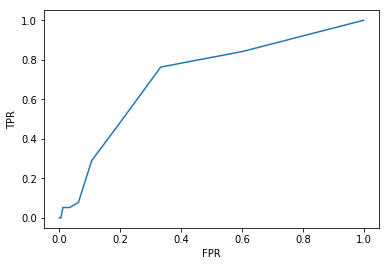

In [209]:
rf = RandomForestClassifier().fit(X_resample, y_resample)
print_scores(rf, X_resample, y_resample, X_test, y_test)
plot_roc(rf, X_test, y_test)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.98      0.60      0.79      0.74      0.69      0.46       762
       True       0.09      0.79      0.60      0.16      0.69      0.48        38

avg / total       0.94      0.61      0.78      0.72      0.69      0.47       800



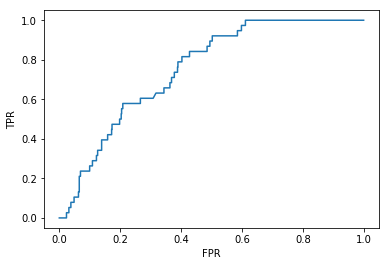

In [210]:
svc = SVC(probability=True, gamma='scale').fit(X_resample, y_resample)
print_scores(svc, X_resample, y_resample, X_test, y_test)
plot_roc(svc, X_test, y_test)

In [223]:
svc_l = SVC(probability=True, kernel='linear').fit(X_resample, y_resample)
print_scores(svc, X_resample, y_resample, X_test, y_test)
plot_roc(svc_l, X_test, y_test)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.98      0.65      0.68      0.78      0.67      0.44       762
       True       0.09      0.68      0.65      0.16      0.67      0.45        38

avg / total       0.93      0.65      0.68      0.75      0.67      0.44       800



TypeError: plot_roc() missing 1 required positional argument: 'name'

In [88]:
dtc = DecisionTreeClassifier().fit(X_resample, y_resample)
y_pred = dtc.predict(X_test)
print_scores(dtc, X_resample, y_resample, X_test, y_test)
plot_roc(dtc, X_test, y_test)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.97      0.85      0.53      0.91      0.67      0.46       762
       True       0.15      0.53      0.85      0.23      0.67      0.43        38

avg / total       0.93      0.84      0.54      0.88      0.67      0.46       800



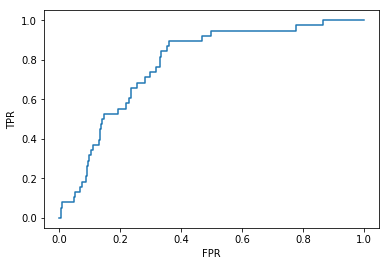

In [213]:
mlp = MLPClassifier(max_iter=2000, early_stopping=True).fit(X_resample, y_resample)
print_scores(mlp, X_resample, y_resample, X_test, y_test)
plot_roc(mlp, X_test, y_test)

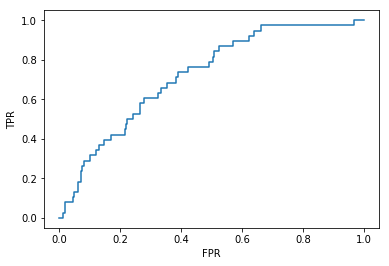

In [151]:
from sklearn.neural_network import MLPRegressor
mlp_r = MLPRegressor(max_iter=2000, early_stopping=True).fit(X_resample, y_resample)
print_scores(mlp_r, X_resample, y_resample, X_test, y_test)
plot_roc(mlp_r, X_test, y_test)

In [ ]:
import pickle
with open('mlp_clf.pkl', 'wb') as f:
    pickle.dump(mlp, f)

In [ ]:
clfs = [text_clf, text_clf_c, lr, knn, svc, svc_l, mlp]
nlp2 = spacy.load(Path("spacy_output"))
names = ["NBC", "CBC", "LR", "kNN", "SVC", "Lin. SVC", "MLP"]
for i, clf in enumerate(clfs):
    try:
        if i in [0,1]:
            y_pred = clf.predict_proba(dev_texts)
            fpr, tpr, _ = roc_curve(dev_cats, y_pred[:,1])
        else:  
            y_pred = clf.predict_proba(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
    except AttributeError:
        y_pred = clf.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.savefig(f'{name}.pdf', format='pdf')
    plt.plot(fpr, tpr, label=names[i])

import operator
X_train_s, X_test_s, y_train, y_test = train_test_split(X[:3200],
                                                    y[:3200], random_state=0)
y_pred = [nlp2(test_text).cats["Relevant"] for test_text in X_test_s]
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.savefig(f'{name}.pdf', format='pdf')
plt.plot(fpr, tpr, label="CNN")
plt.legend(loc=4)

plt.show()

## Other classifier

In [ ]:
gs = GridSearchCV(LogisticRegression(), 
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1]}, scoring="roc_auc", cv=4)
gs = gs.fit(X_resample, y_resample)
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
gs = GridSearchCV(LinearSVC(), 
             param_grid=param_grid, scoring="roc_auc", cv=4)
gs = gs.fit(X_resample, y_resample)
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

In [ ]:
param_grid = {'activation': ['relu', 'logistic', 'tanh'],
              'alpha': [0.0001, 0.001, 0.01],
              'learning_rate': ['constant', 'invscaling', 'adaptive'], 'tol': [0.01]}
gs = GridSearchCV(MLPClassifier(), 
             param_grid=param_grid, scoring="roc_auc", cv=4)
gs = gs.fit(X_transform, y[:3200])
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
X_transform_cluster = KMeans(n_clusters=5).fit_transform(X_transform, y[:3200])

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resample_cluster, y_resample_cluster = rus.fit_sample(X_transform_cluster, y[:X_transform_cluster.shape[0]])

In [ ]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_resample_cluster,
                                                    y_resample_cluster, stratify=y_resample_cluster, random_state=0)

In [ ]:
lr = LogisticRegression()
print_scores(lr, X_train_cluster, y_train_cluster, X_test_cluster, y_test_cluster)
plot_roc(lr, X_test_cluster, y_test_cluster)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X_transform_pca = PCA().fit_transform(X_transform, y[:3200])

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resample_pca, y_resample_pca = rus.fit_sample(X_transform_pca, y[:X_transform_pca.shape[0]])

In [ ]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_resample_cluster,
                                                    y_resample_cluster, stratify=y_resample_cluster, random_state=0)

In [ ]:
lr = LogisticRegression()
print_scores(lr, X_train_cluster, y_train_cluster, X_test_cluster, y_test_cluster)
plot_roc(lr, X_test_cluster, y_test_cluster)

In [1]:
from web_app.app import summarize

In [ ]:
summarize('https://www.who.int/csr/don/04-march-2019-mers-oman/en/')